In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import sys
from PIL import Image
from matplotlib import pyplot as plt
from dataset.droplets import DropletDataset
from torch.utils.data import DataLoader
from model.Unninet import UnniNet
import torch
import torchvision
%matplotlib inline

In [2]:
ROOT_DIR = r"data\m_crop"
TEST_CSV = r"data\m_crop\test.csv"
MODEL_NAME = "train_3\model200.torch"
modelPath = os.path.join(r"model", MODEL_NAME)

In [12]:
imgpaths = []
path_prefix = "E:\Academics\DDP\Data\Defocused\jpg\m\\"
for folder in os.listdir("E:\Academics\DDP\Data\Defocused\jpg\m\\"):
    for imgname in os.listdir(path_prefix + folder):
        if imgname.endswith(".jpg"):
            _name = [imgname]
            _name.append(path_prefix + folder + "\\" + imgname)
            _name.append(int(folder[1:]))
            imgpaths.append(_name)
print(len(imgpaths))
print(imgpaths[85])

919
['m_0003_1400.jpg', 'E:\\Academics\\DDP\\Data\\Defocused\\jpg\\m\\m1400\\m_0003_1400.jpg', 1400]


In [13]:
def label_droplets(label, origin, img):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.8
    color = (255, 0, 0)
    thickness = 1
    text = str(label) + " mm"
    img = cv2.putText(img, text, origin, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    return img

In [14]:
default_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels = 1),
    torchvision.transforms.Normalize((0.5), (0.5)),
    ]
)

In [15]:
def predict(ROI):
    ROI = default_transforms(ROI).unsqueeze(0).to(device)
    pred = model(ROI)
    out = 20 + torch.sigmoid(pred) * 1380
    print(out)
    return out.item()

In [16]:
# Load image, grayscale, Threshold 
def crop_defocus(imgdata, model):
    image = cv2.imread(imgdata[1])
    print(imgdata[0])
    original = image.copy()
    gray = cv2.blur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),(5,5))
    thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]
    
    # Find contours, obtain bounding box, extract and save ROI
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    #Sorting the countours in descending order of area to get only the droplets and not noise
    cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[2]*cv2.boundingRect(x)[3], reverse=True)
    
    #Creating bounding boxes for the detected countours, creating 360 x 360 crops of the ROIs
    for i in range(3):
        x,y,w,h = cv2.boundingRect(cnts[i])
        if w/h > 0.8 and w/h < 1.2:
            x_center = int(0.5*(2*x + w))
            y_center = int(0.5*(2*y + h))
            x_left = max((x_center - 180), 0)
            y_left = max((y_center - 180), 0)
            x_right = min((x_center + 180), image.shape[1])
            y_right = min((y_center + 180), image.shape[0])
#             cv2.rectangle(image, (x_left, y_left), (x_right, y_right), (36,255,12), 2)
            ROI = original[y_left:y_right, x_left:x_right]
            
            if ROI.shape[0] != 360 or ROI.shape[1] != 360:
                ROI = cv2.resize(ROI, (360,360), interpolation = cv2.INTER_AREA)
            ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
            ROI_pil = Image.fromarray(ROI)
            origin = (x_center, y_right)
            label = predict(ROI_pil)
            image = label_droplets(label, origin, image)
    fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    return image

In [8]:
test_dataset = DropletDataset(root_dir = ROOT_DIR, annotations_path = TEST_CSV)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnniNet()
model = model.to(device)
print(device)

cuda


In [18]:
#----------------Load State--------------------------------------------------------------------------
model.load_state_dict(torch.load(modelPath, map_location= device)) # Load trained model
model.eval() # Set net to evaluation mode, usually usefull in this case its fail

UnniNet(
  (model): Sequential(
    (0): ConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (model): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (model): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ConvBlock(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
      )
    )
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ConvBlock(
      (model): Sequential(
        (0):

m_0076_700.jpg
tensor([[696.7375]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[708.6262]], device='cuda:0', grad_fn=<AddBackward0>)


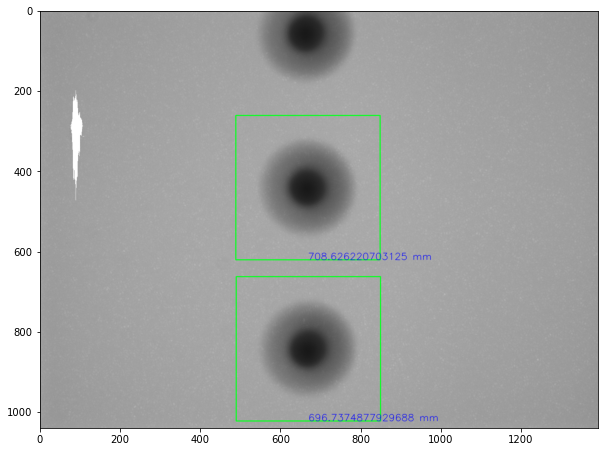

array([[[158, 158, 158],
        [151, 151, 151],
        [156, 156, 156],
        ...,
        [151, 151, 151],
        [150, 150, 150],
        [153, 153, 153]],

       [[161, 161, 161],
        [152, 152, 152],
        [158, 158, 158],
        ...,
        [154, 154, 154],
        [152, 152, 152],
        [151, 151, 151]],

       [[158, 158, 158],
        [150, 150, 150],
        [154, 154, 154],
        ...,
        [158, 158, 158],
        [153, 153, 153],
        [150, 150, 150]],

       ...,

       [[160, 160, 160],
        [151, 151, 151],
        [158, 158, 158],
        ...,
        [152, 152, 152],
        [154, 154, 154],
        [152, 152, 152]],

       [[161, 161, 161],
        [152, 152, 152],
        [154, 154, 154],
        ...,
        [156, 156, 156],
        [156, 156, 156],
        [157, 157, 157]],

       [[162, 162, 162],
        [150, 150, 150],
        [153, 153, 153],
        ...,
        [154, 154, 154],
        [153, 153, 153],
        [153, 153, 153]]

In [23]:
crop_defocus(imgpaths[700], model)